# 주제 : 공동주택 전력수요 예측 개선

* 기상변수 및 공공데이터 등 활용 공동주택 전력수요 증감 영향 요인 분석
* 계절, 지역에 따른 모델 세분화를 통한 공동주택 전력 수요 예측 (전력기상지수) 최적모델 개발
* 전력기상지수 : 기상변화에 따른 지역별 공동주택의 예상되는 전력부하 변화를 기상예보처럼 국민들이 쉽게 인지할 수 있도록 수치화하여 예측해주는 서비스


# Column Information

* num : 격자 넘버 - 기상청 동네예보 격자넘버
* tm : 날짜 - 공동주택 전력부하 측정 날짜 시간포함, 단위(0 ~ 23시)
* hh24 : 시간 - 공동주택 전력부하 측정 시간(1 ~ 24), 5시는 4시 1분 ~ 5시 00분 까지 전력 부하를 의미
* n : 공동주택 수 - 해당격자의 전력통계 산출에 포함된 공동주택의 수, 단위(단지)
* stn : 지점 번호 - AWS 지점 번호, AWS(Automated Weather Station, 자동기상관측장비)는 과거에 사람이 직접 관측하던 것을 자동으로 관측할 수 있도록 설계한 기상관측장비
* sum_qctr : 계약전력합계 - 해당격자의 전력통계 산출에 포함된 공동주택의 계약전력 합계
* sum_load : 전력수요합계 - 해당격자/시각에 측정된 공동주택의 전력수요 합계
* n_mean_load : 전력부하량평균 - 격자내 총 전력부하량을 아파트 수로 나누어 격자의 평균 부하량을 산출
* nph_ta : 기온 - 단위(C)
* nph_hm : 상대습도 - 단위(%)
* nph_ws_10m : 풍속 - 객관분석 10분 평균 풍속, 단위(m/s)
* nph_rn_60m : 강수량 - 객관분석 1시간 누적 강수량, 단위(mm)
* nph_ta_chi : 체감온도 - 단위(C)
* weekday : 요일 - 요일을 숫자형식으로 표시 월요일(0) ~ 일요일(6)
* week_name : 주중 주말 - 주중 주말을 숫자형식으로 표시, 주중(0) ~ 주말(1)
* elec : 전력기상지수(TARGET) - 해당 격자의 공동주택의 연평균 부하량을 100으로 했을 때, 해당 시작에 예상되는 부하량을 상대적인 수치로 표현

# 주의할 점

* test 데이터는 전력기상지수를 산출할 수 있는 변수인 sum_qctr, n, sum_load, n_mean_load를 제외하고 제공됨

# 데이터 & 라이브러리 불러오기

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import GridSearchCV

from scipy.stats import skew



import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/Users/jangjuik/Desktop/electric/electric_train_mac.csv', index_col = 0)
test = pd.read_csv('/Users/jangjuik/Desktop/electric/electric_test_mac.csv', index_col = 0)

In [3]:
train.head()

,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
1,4821,2021-01-01 01:00:00,1,11,884,6950,751.32,68.606449,2.2,62.7,1.8,0.0,-1.0,4,0,99.56
2,4821,2021-01-01 02:00:00,2,11,884,6950,692.60,68.606449,2.3,63.1,2.1,0.0,-0.6,4,0,91.78
3,4821,2021-01-01 03:00:00,3,11,884,6950,597.48,68.606449,2.2,62.4,2.5,0.0,-1.3,4,0,79.17
4,4821,2021-01-01 04:00:00,4,11,884,6950,553.48,68.606449,1.7,63.5,1.7,0.0,-0.2,4,0,73.34
5,4821,2021-01-01 05:00:00,5,11,884,6950,526.24,68.606449,1.7,63.0,1.6,0.0,-0.8,4,0,69.73


# 시간 관련 피처 생성

In [4]:
# 컬럼명 변경
train.columns = train.columns.str.replace('electric_train.', '')
test.columns = test.columns.str.replace('electric_test.', '')

# 시간 관련 변수 생성
train['tm'] = pd.to_datetime(train['tm'], format = '%Y-%m-%d %H:%M:%S')

train['Year'] = train['tm'].dt.year
train['Month'] = train['tm'].dt.month
train['day'] = train['tm'].dt.day

test['tm'] = pd.to_datetime(test['tm'], format = '%Y-%m-%d %H:%M:%S')

test['Year'] = test['tm'].dt.year
test['Month'] = test['tm'].dt.month
test['day'] = test['tm'].dt.day

# EDA

## 1) 전력기상지수 분포

Text(0.5, 0, 'Elec')

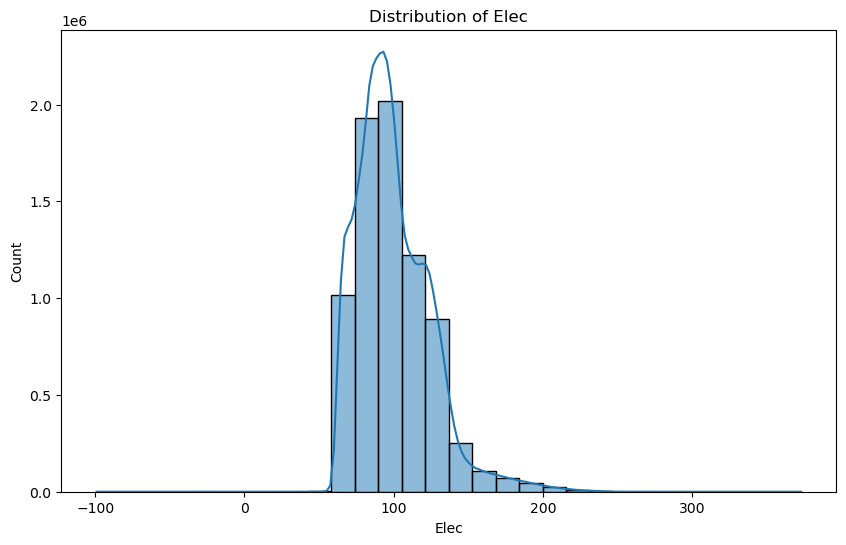

In [5]:
plt.figure(figsize = (10, 6))
sns.histplot(train['elec'], bins = 30, kde = True)
plt.title('Distribution of Elec')
plt.xlabel('Elec')

## 2) 변수들의 상관관계 파악

<Axes: >

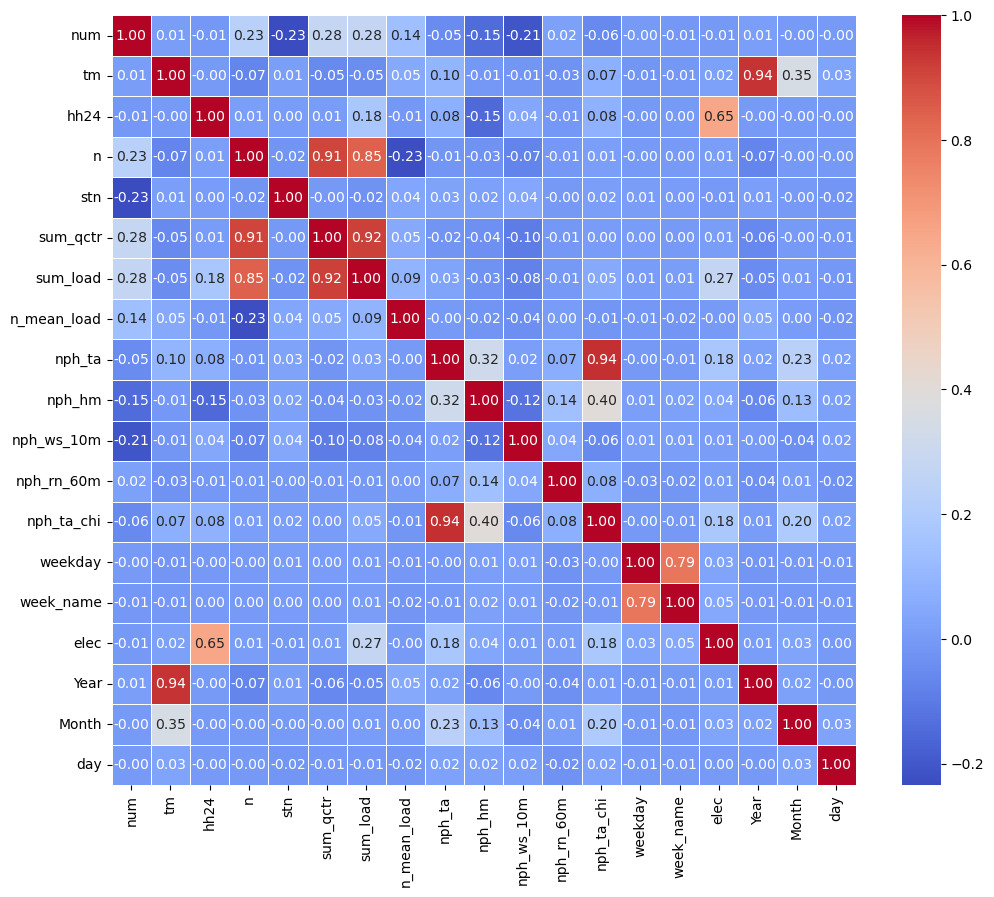

In [6]:
sample_data = train.sample(n = 10000, random_state = 42)
corr_matrix = sample_data.corr()
plt.figure(figsize = (12, 10))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', linewidth = 0.5)

전력기상지수와 상관관계가 높은 변수는 hh24, sum_load, nph_ta, nph_ta_chi, week_name, nph_hm, weekday, Month, tm 순이다.


## 3) 전력기상지수 평균 분포 시각화

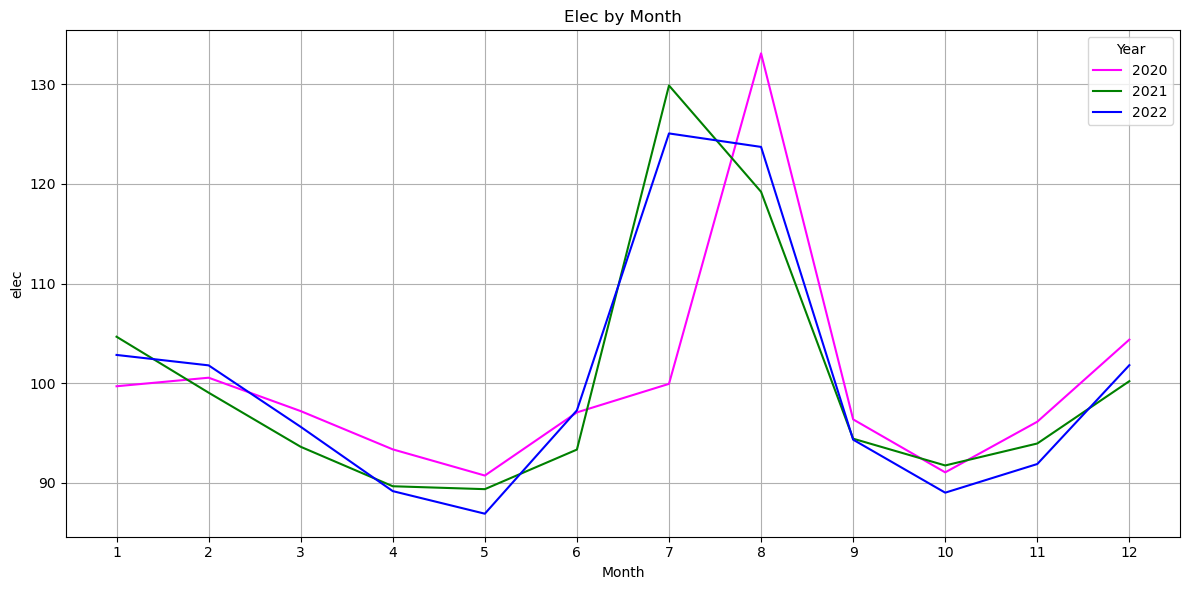

In [7]:
# 월별 전력기상지수(elec)를 평균내어 그래프로 시각화

colors = ['magenta', 'green', 'blue']

monthly_elec = train.groupby(['Year', 'Month'])['elec'].mean()[:-1].reset_index()  # 2023년 1월 제외
grouped_data_elec = monthly_elec.groupby('Year')

plt.figure(figsize = (12,6))

for i, (year, group) in enumerate(grouped_data_elec):
    plt.plot(group['Month'], group['elec'], label = f'{year}', color = colors[i])

plt.title('Elec by Month')
plt.xlabel('Month')
plt.ylabel('elec')
plt.xticks(range(1, 13), [str(month) for month in range(1, 13)])
plt.legend(title = 'Year')
plt.grid(True)
plt.tight_layout()
plt.show()

여름에 전력기상지수가 높게 나타나는 것을 알 수 있음

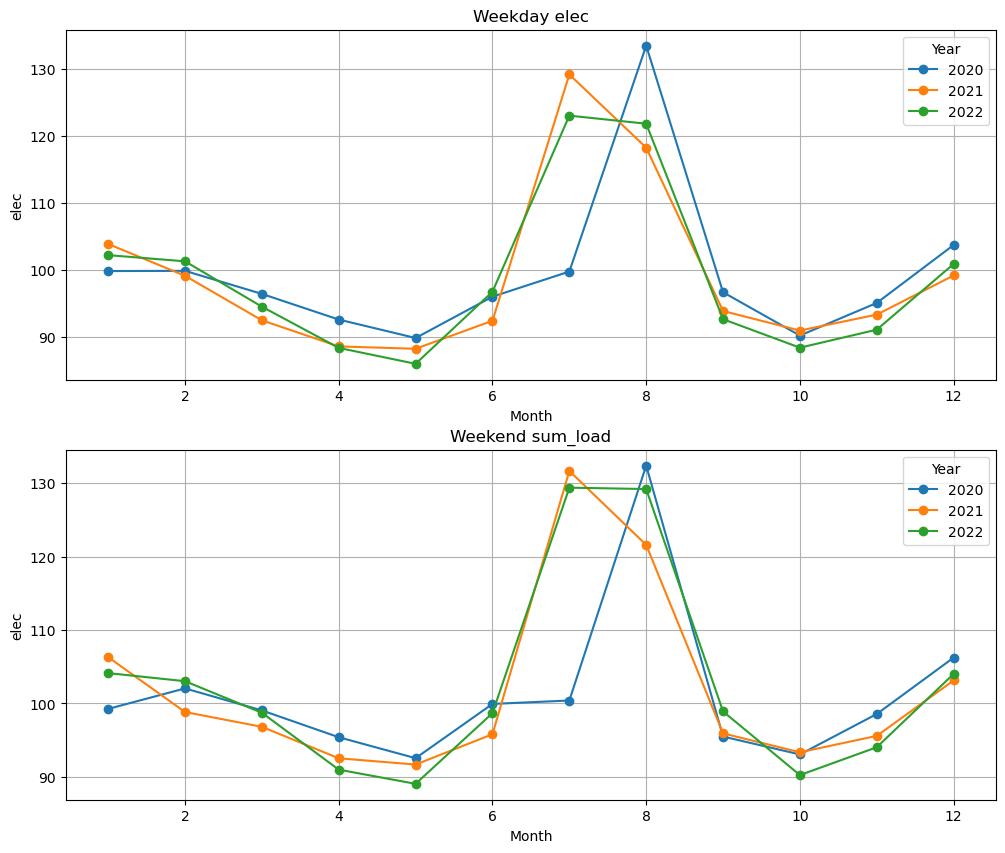

In [8]:
# 전력기상지수(elec)를 주중과 주말로 나눠서 시각화

monthly_wn = train.groupby(['Year','Month','week_name'])['elec'].mean()[:-1].reset_index()  # 2023년 1월 1일 제외

weekday_data = monthly_wn[monthly_wn['week_name'] == 0]
weekend_data = monthly_wn[monthly_wn['week_name'] == 1]

weekday_grouped = weekday_data.groupby(['Year', 'Month']).first()
weekend_grouped = weekend_data.groupby(['Year', 'Month']).first()

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 10))

# 주중 그래프
for year, group in weekday_grouped.groupby(level = 0):
    axes[0].plot(group.index.get_level_values('Month'), group['elec'], marker = 'o', label = f'{year}')
axes[0].set_title('Weekday elec')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('elec')
axes[0].legend(title = 'Year')
axes[0].grid(True)

# 주말 그래프
for year, group in weekend_grouped.groupby(level = 0):
    axes[1].plot(group.index.get_level_values('Month'), group['elec'], marker = 'o', label = f'{year}')
axes[1].set_title('Weekend sum_load')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('elec')
axes[1].legend(title = 'Year')
axes[1].grid(True)

전력기상지수는 주중과 주말 비슷한 양상을 보인다.

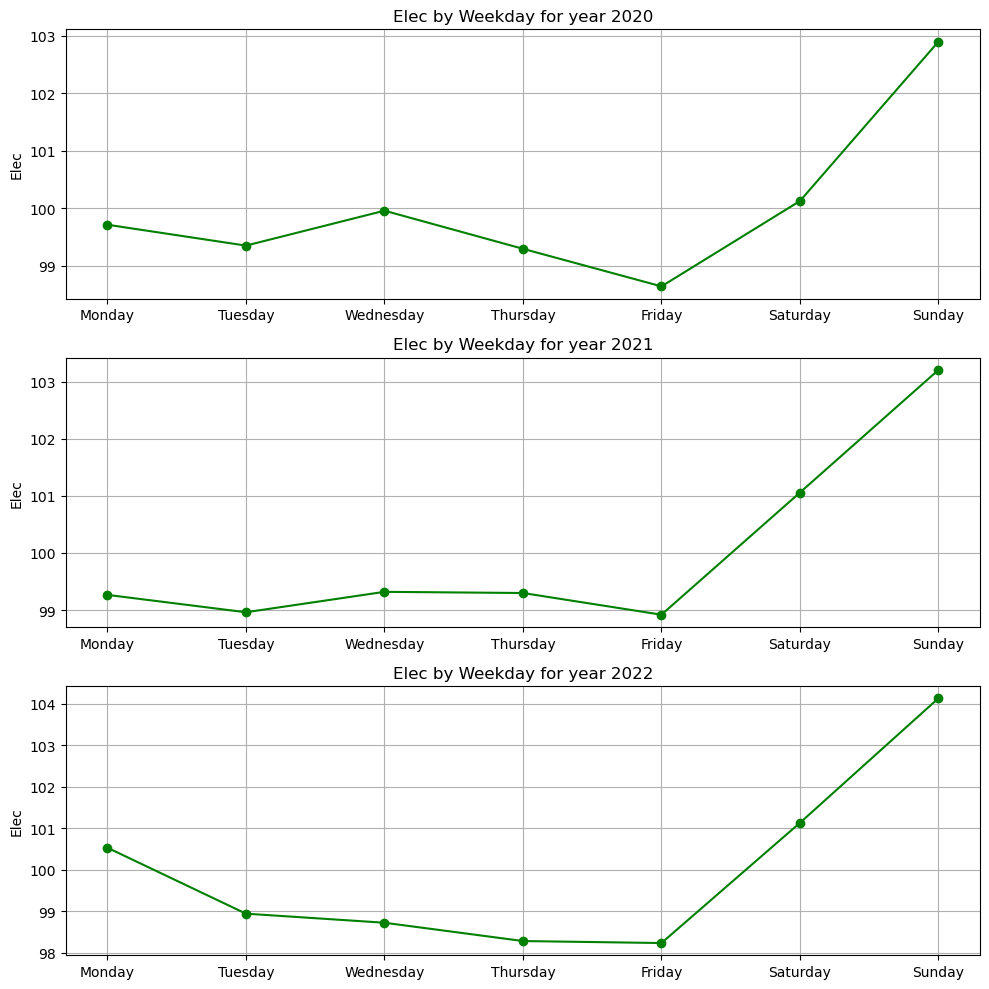

In [9]:
# 전력기상지수(elec)를 요일별로 나눠서 시각화

day_data = train.groupby(['Year','weekday'])['elec'].mean()[:-1].reset_index() # 2023년 1월 1일 제외

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 10))

for i, year in enumerate(day_data['Year'].unique()):
    year_data = day_data[day_data['Year'] == year]
    axes[i].plot(year_data['weekday'], year_data['elec'], marker = 'o', color = 'green')
    axes[i].set_title(f'Elec by Weekday for year {year}')
    axes[i].set_ylabel('Elec')
    axes[i].set_xticks(range(7))
    axes[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    axes[i].grid(True)

plt.tight_layout()
plt.show()

전력기상지수는 주말에 더 높게 나타나는 모습을 보임. 아마도 주말에는 출근하지 않는 사람이 많다보니 공동주택 전력수요가 증가해서 그런듯함

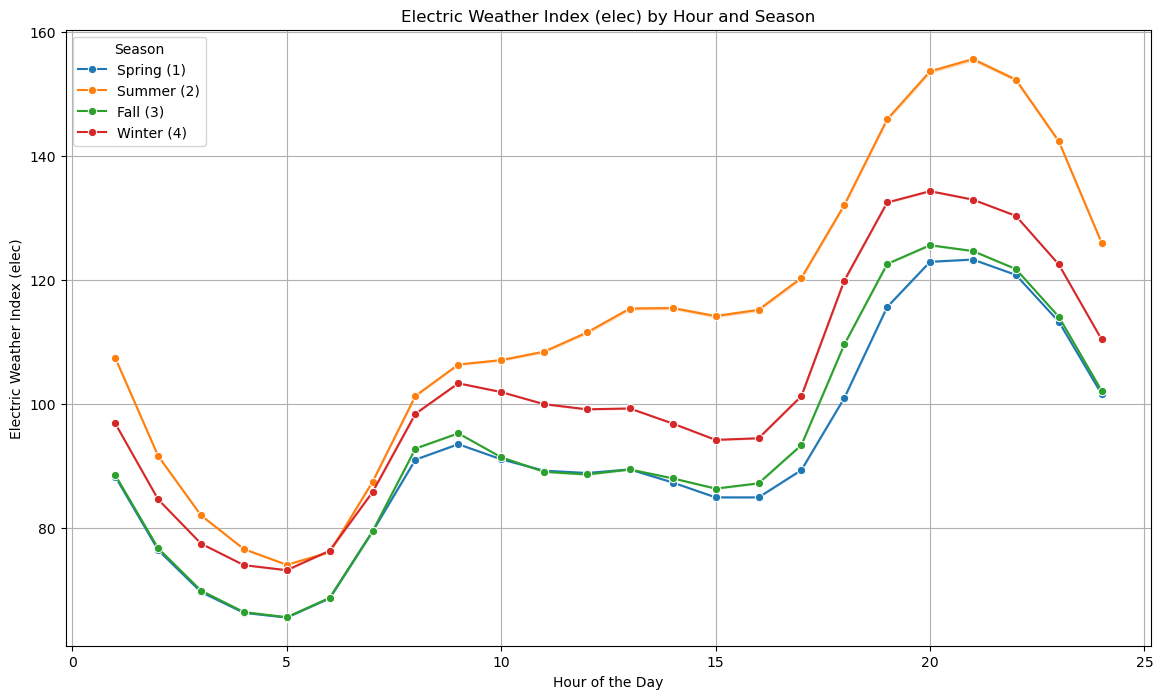

In [10]:
# 계절별 시간대별 전력기상지수 시각화

conditions = [
    train['Month'].isin([3, 4, 5]),
    train['Month'].isin([6, 7, 8]),
    train['Month'].isin([9, 10, 11]),
    train['Month'].isin([12, 1, 2])
]

choices = [1, 2, 3, 4]

train['Season'] = np.select(conditions, choices, default=0)

conditions_test = [
    test['Month'].isin([3, 4, 5]),
    test['Month'].isin([6, 7, 8]),
    test['Month'].isin([9, 10, 11]),
    test['Month'].isin([12, 1, 2])
]

choices = [1, 2, 3, 4]

test['Season'] = np.select(conditions_test, choices, default=0)

plt.figure(figsize=(14, 8))
plot = sns.lineplot(data=train, x='hh24', y='elec', hue='Season', palette='tab10', marker='o')

# 범례 수정
handles, labels = plot.get_legend_handles_labels()
new_labels = ['Spring (1)', 'Summer (2)', 'Fall (3)', 'Winter (4)']
plot.legend(handles=handles, labels=new_labels, title='Season')

plt.title('Electric Weather Index (elec) by Hour and Season')
plt.xlabel('Hour of the Day')
plt.ylabel('Electric Weather Index (elec)')
plt.grid(True)
plt.show()


여름에 전력기상지수가 가장 높게 나타나고, 그 다음으로 겨울이 높게 나타나는 것을 알 수 있음<br>
또한, 오후 4시부터 증가하기 시작하여 오후 8-9시 쯤에 피크

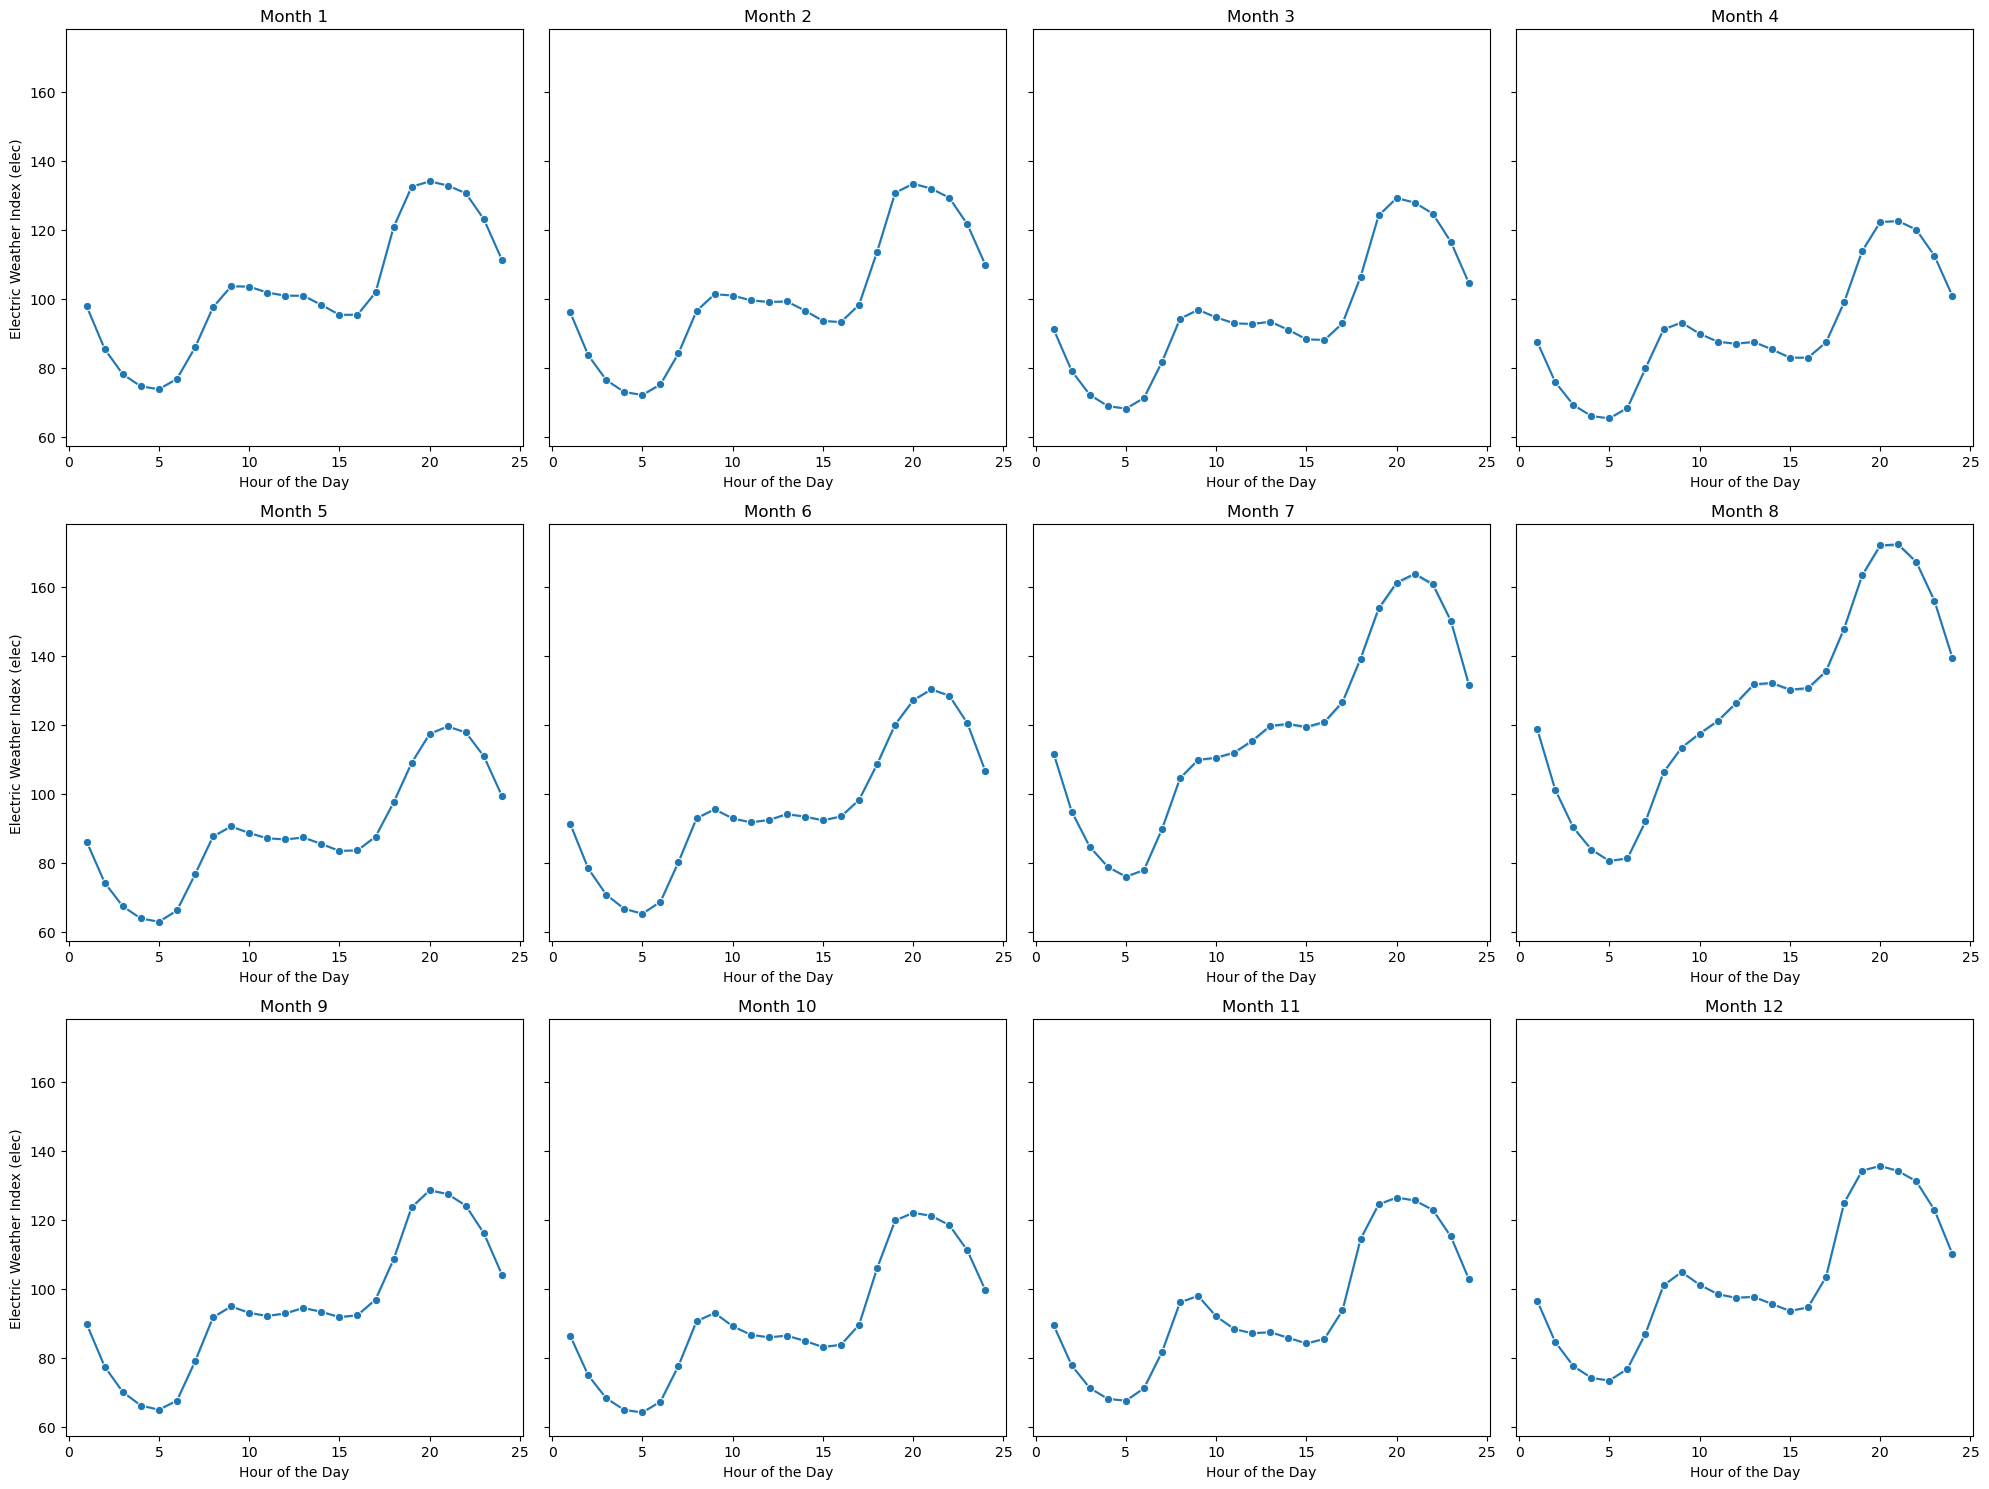

In [11]:
# 월별 시간대에 따른 전력기상지수(elec)를 시각화

# 서브플롯 생성
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True)
axes = axes.flatten()

# 각 월별로 서브플롯에 그래프 그리기
for i in range(1, 13):
    ax = axes[i - 1]
    month_data =train[train['Month'] == i]
    if not month_data.empty:
        sns.lineplot(data=month_data, x='hh24', y='elec', ax=ax, marker='o')
        ax.set_title(f'Month {i}')
        ax.set_xlabel('Hour of the Day')
        ax.set_ylabel('Electric Weather Index (elec)')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

전력부하가 많은 7,8월에 전력기상지수가 가장 높게 나타나고, 항상 오후 8-9시쯤이 피크


# 아파트 매매 가격과 전력 수요량의 관계

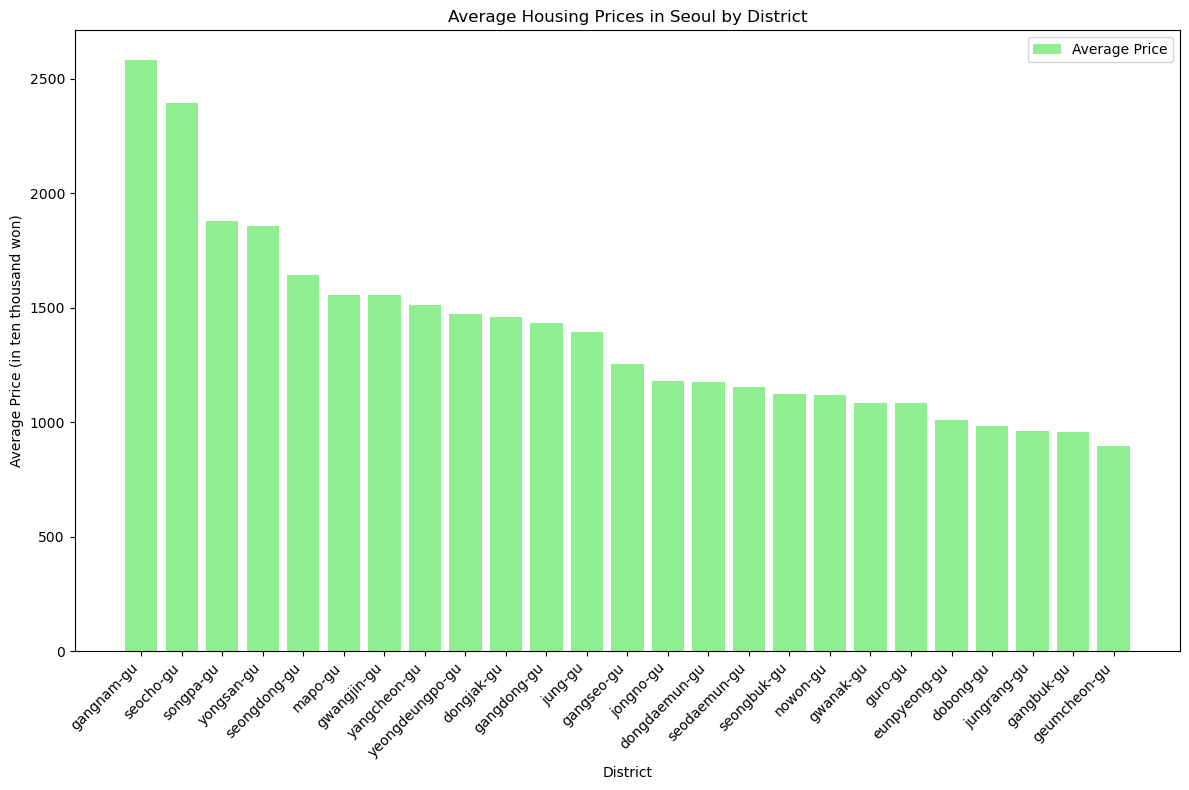

In [12]:
# 아파트 ㎡당 매매평균가격(최근 5년)
apartment = pd.read_excel('/Users/jangjuik/Desktop/electric/code/아파트 ㎡당 매매평균가격_20240603.xlsx')
apartment = apartment.transpose()
apartment = apartment.drop(apartment.index[0]).reset_index()
new_columns = ['DateTime', '강북14개구', '종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', 
               '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '강남11개구', '양천구', '강서구', '구로구', 
               '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']
apartment.columns = new_columns

apartment['DateTime'] = pd.to_datetime(apartment['DateTime'])

# 2022년 데이터만 필터링
apartment_2022 = apartment[apartment['DateTime'].dt.year == 2022]

# 서울시 모든 구의 평균 매매가격 구하기
seoul_avg_price = apartment_2022.drop(columns=['DateTime', '강북14개구', '강남11개구']).mean().sort_values(ascending = False)

korean_to_english = {
    '종로구': 'jongno-gu',
    '중구': 'jung-gu',
    '용산구': 'yongsan-gu',
    '성동구': 'seongdong-gu',
    '광진구': 'gwangjin-gu',
    '동대문구': 'dongdaemun-gu',
    '중랑구': 'jungrang-gu',
    '성북구': 'seongbuk-gu',
    '강북구': 'gangbuk-gu',
    '도봉구': 'dobong-gu',
    '노원구': 'nowon-gu',
    '은평구': 'eunpyeong-gu',
    '서대문구': 'seodaemun-gu',
    '마포구': 'mapo-gu',
    '양천구': 'yangcheon-gu',
    '강서구': 'gangseo-gu',
    '구로구': 'guro-gu',
    '금천구': 'geumcheon-gu',
    '영등포구': 'yeongdeungpo-gu',
    '동작구': 'dongjak-gu',
    '관악구': 'gwanak-gu',
    '서초구': 'seocho-gu',
    '강남구': 'gangnam-gu',
    '송파구': 'songpa-gu',
    '강동구': 'gangdong-gu'
}
english_district_prices = {korean_to_english[key]: value for key, value in seoul_avg_price.items()}

plt.figure(figsize=(12, 8))
plt.bar(english_district_prices.keys(), english_district_prices.values(), color='lightgreen')
plt.title('Average Housing Prices in Seoul by District')
plt.xlabel('District')
plt.ylabel('Average Price (in ten thousand won)')
plt.xticks(rotation=45, ha='right')
plt.legend(['Average Price'], loc='upper right')
plt.tight_layout()
plt.show()

In [13]:
# 가구 평균 전력 사용량 데이터(서울시 2022-01 ~ 2022-12)
house1 = pd.read_excel("/Users/jangjuik/Desktop/electric/code/가구 평균 월별 전력사용량_210106.xls")
house2 = pd.read_excel("/Users/jangjuik/Desktop/electric/code/가구 평균 월별 전력사용량_210712.xls")
house1 = house1.drop(house1.index[:3])
house1.index = range(len(house1))
new_columns = ['Datetime', '시도', '시군구', '대상가구수(호)', '가구당 평균 전력 사용량(kWh)', '가구당 평균 전기요금(원)']
house1.columns = new_columns

house2 = house2.drop(house2.index[:3])
house2.index = range(len(house2))
new_columns = ['Datetime', '시도', '시군구', '대상가구수(호)', '가구당 평균 전력 사용량(kWh)', '가구당 평균 전기요금(원)']
house2.columns = new_columns

house = pd.concat([house1, house2])

house = house[house['Datetime'] != '년월']
house = house[house['시군구'] != '전체']
house = house.dropna()
house.index = range(len(house))

house['Datetime'] = pd.to_datetime(house['Datetime'], format='%Y%m')

# '대상가구수(호)' 열의 쉼표 제거 후 정수형으로 변환
house['대상가구수(호)'] = house['대상가구수(호)'].str.replace(',', '').astype(int)

# '가구당 평균 전기요금(원)' 열의 쉼표 제거 후 정수형으로 변환
house['가구당 평균 전기요금(원)'] = house['가구당 평균 전기요금(원)'].str.replace(',', '').astype(int)

house['대상가구수(호)'] = house['대상가구수(호)'].astype(int)
house['가구당 평균 전력 사용량(kWh)'] = house['가구당 평균 전력 사용량(kWh)'].astype(int)
house['가구당 평균 전기요금(원)'] = house['가구당 평균 전기요금(원)'].astype(int)

all_gu_df = pd.DataFrame(columns=house.columns)

for gu in house['시군구'].unique():
    gu_df = house[house['시군구'] == gu]
    all_gu_df = pd.concat([all_gu_df, gu_df])

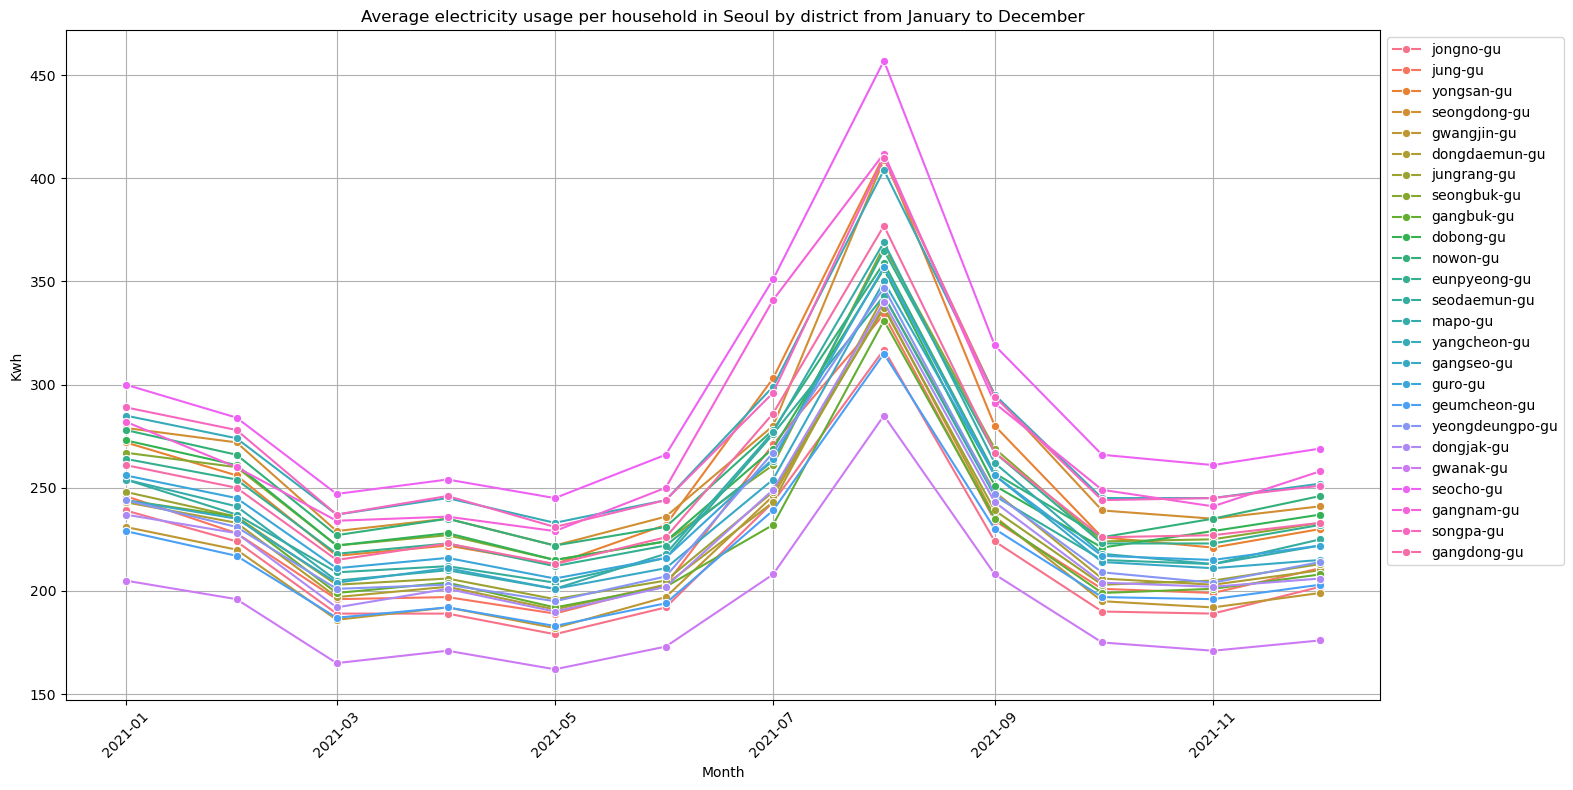

In [14]:
# 시각화

plt.figure(figsize=(14, 8))

# 각 선에 대한 영어 이름 설정 및 색상 팔레트 변경
colors = sns.color_palette("husl", len(korean_to_english))
for i, (gu_korean, gu_english) in enumerate(korean_to_english.items()):
    gu_df = all_gu_df[all_gu_df['시군구'] == gu_korean]
    sns.lineplot(data=gu_df, x='Datetime', y='가구당 평균 전력 사용량(kWh)', label=gu_english, marker='o', color=colors[i])

plt.title('Average electricity usage per household in Seoul by district from January to December')
plt.xlabel('Month')
plt.ylabel('Kwh')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 범례 위치 조정
plt.legend(bbox_to_anchor=(1, 1), ncol=1)

plt.show()

2022년의 서울시 구별 아파트 평균 매매가격을 시각화해보니, <br>
강남구가 2582만원으로 가장 높고, 금천구가 898만원으로 가장 낮게 나타났다. <br>

2022년 1월 ~ 2022년 12월 서울시 구별 가구당 평균 전력 사용량(kWh)을 시각화해보니,<br>
8월에는 서초구가 416으로 가장 높고, 관악구가 259로 가장 낮게 나타났다.<br>
관악구는 2022년에 1인가구의 수가 약 17만으로, 전체 가구 수의 60%에 해당한다.<br>

아파트 평균 매매가격과 전력 사용량에는 상관이 다소 있는 것으로 보인다.<br>
매매가격 상위 구역과 전력 사용량 상위 구역은 비슷하게 나타난다.<br>

In [15]:
avg_power_usage = house.groupby('시군구')['가구당 평균 전력 사용량(kWh)'].mean().sort_values(ascending = False)
seoul_avg_price = apartment_2022.drop(columns=['DateTime', '강북14개구', '강남11개구']).mean().sort_values(ascending = False)

df_avg_power_usage = pd.DataFrame(list(avg_power_usage.items()), columns=['시군구', '가구당 평균 전력 사용량(kWh)'])
df_seoul_avg_price = pd.DataFrame(list(seoul_avg_price.items()), columns=['시군구', '평균매매가격'])

merged_df = pd.merge(df_avg_power_usage, df_seoul_avg_price, on='시군구')

# 시군구를 기준으로 데이터프레임 정렬
merged_df.sort_values(by='시군구', inplace=True)

# '시군구' 열을 인덱스로 설정
merged_df.set_index('시군구', inplace=True)

# 상관관계 계산
correlation = merged_df.corr(method='pearson')

# 결과 출력
print(correlation)

                    가구당 평균 전력 사용량(kWh)    평균매매가격
가구당 평균 전력 사용량(kWh)            1.000000  0.665597
평균매매가격                        0.665597  1.000000


아파트 평균매매가격과 가구당 평균 전력 사용량에는 약 0.666의 양의 상관이 있다.

# 데이터 전처리

<Figure size 800x600 with 0 Axes>

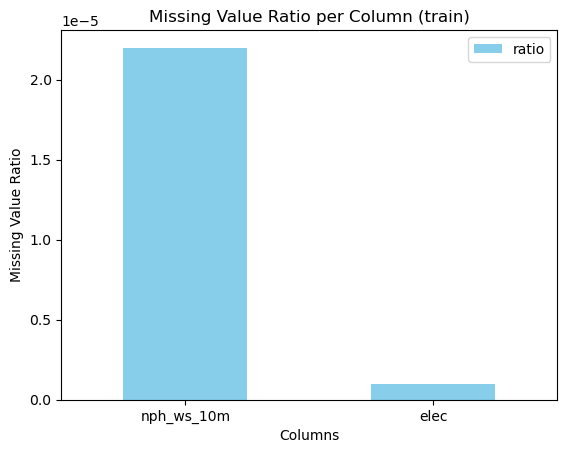

In [16]:
########################################
# 결측치 처리
########################################

train.replace(-99, np.nan, inplace = True)
test.replace(-99, np.nan, inplace = True)

missing_ratio_train = train.isnull().mean().sort_values(ascending = False).apply(lambda x : round(x, 6))
columns = ['ratio']
missing_df_train = pd.DataFrame(missing_ratio_train, columns = columns)
missing_column_train = missing_df_train[missing_df_train['ratio'] > 0]

plt.figure(figsize = (8, 6))
missing_column_train.plot(kind = 'bar', color = 'skyblue')
plt.xlabel('Columns')
plt.ylabel('Missing Value Ratio')
plt.title('Missing Value Ratio per Column (train)')
plt.xticks(rotation = 0)
plt.show()

In [17]:
# 테스트 셋은 결측치가 없음
# 시계열 데이터나 연속된 수치를 가지는 데이터의 경우에는 일종의 연속성이 있는 패턴을 발견할 수 있음
# 이런 경우 보간법을 통해 앞, 뒤 값을 유추하여 결측치를 채워줄 수 있음
# 여기서는 선형 보간법을 사용했음

train['elec'] = train['elec'].interpolate(method = 'linear')
train['nph_ws_10m'] = train['nph_ws_10m'].interpolate(method = 'linear')

In [18]:
########################################
# 이상치 탐색
########################################

# 기온, 상대습도, 풍속, 강수량, 체감온도의 이상치를 탐색한다
# Box plot으로 분포 살펴보기

# numeric_df = train[['nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_ta_chi']]

# fig, axes = plt.subplots(2, 2, figsize = (15, 10))

# for i, col in enumerate(numeric_df.columns):
    # sns.boxplot(x = numeric_df[col], ax = axes[i // 2, i % 2])
    # axes[i // 2, i % 2].set_title(f'Box plot for {col}')
# plt.tight_layout()
# plt.show()

# 각 column에 대한 이상치 탐색(IQR 기반)

# total_rows = train.shape[0]
# outliers_ratios = {}

# sets_index = set()
# for col in numeric_df.columns:
    # Q1 = numeric_df[col].quantile(0.25)
    # Q3 = numeric_df[col].quantile(0.75)

    # IQR = Q3 - Q1

    # upper_bound = Q3 + 1.5 * IQR
    # lower_bound = Q1 - 1.5 * IQR


    # outliers = numeric_df[(numeric_df[col] < lower_bound)| (numeric_df[col] > upper_bound)]

    # outlier_ratio = len(outliers) / total_rows
    # outliers_ratios[col] = outlier_ratio

    # outliers_index = numeric_df[(numeric_df[col] < lower_bound)| (numeric_df[col] > upper_bound)].index

    # sets_index.update(outliers_index)

# for col, ratio in outliers_ratios.items():
    # print(f'{col} 열의 이상치 비율 : {ratio : .2%}')

# train = train.drop(sets_index).reset_index(drop = True)

In [19]:
########################################
# 로그변환 
########################################

# 변수들의 왜도 파악하기
# columns_to_visualize = ['nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_rn_60m', 'nph_ta_chi']
# fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 5))

# 각 열에 대해 히스토그램 그리기
# for i, column in enumerate(columns_to_visualize):
    # ax = axes[i]
    # ax.hist(train[column], bins = 30, color = 'skyblue', edgecolor = 'black')
    # ax.set_title(column)
    # ax.set_xlabel('Value')
    # ax.set_ylabel('Frequency')
    # ax.grid(True)

# plt.tight_layout()
# plt.show()

# skewness = train[columns_to_visualize].skew()
# print(skewness)

# nph_ws_10m, nph_rn_60m 변수의 로그변환을 진행

# train['nph_ws_10m_log'] = np.log1p(train['nph_ws_10m'])
# train['nph_rn_60m_log'] = np.log1p(train['nph_rn_60m'])

# test['nph_ws_10m_log'] = np.log1p(test['nph_ws_10m'])
# test['nph_rn_60m_log'] = np.log1p(test['nph_rn_60m'])

# fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
# log_columns = ['nph_rn_60m_log', 'nph_ws_10m_log']

# 로그변환 후 히스토그램 그리기
# for i, column in enumerate(log_columns):
    # ax = axes[i]
    # ax.hist(train[column], bins = 30, color = 'skyblue', edgecolor = 'black')
    # ax.set_title(column)
    # ax.set_xlabel('Value')
    # ax.set_ylabel('Frequency')
    # ax.grid(True)

# plt.tight_layout()
# plt.show()   

이상치 처리(성능변화있음) 로그 변환을 해도 성능변화가 뚜렷하게 나타나지 않음. (다른 방법을 찾아야 할 듯)

In [20]:
########################################
# sin, cos 시간 변수 생성
########################################

# 시간이 1 ~ 24로 주어진다. 01시와 24시는 매우 가까운 시간인데, 컴퓨터는 멀다고 인식을 하므로
# 이를 보완하기 위해 sin 시간과 cos 시간 feature를 만들었다

train['sin_time'] = np.sin(2 * np.pi * train.hh24 / 24)
test['sin_time'] = np.sin(2 * np.pi * test.hh24 / 24)


train['cos_time'] = np.cos(2 * np.pi * train.hh24 / 24)
test['cos_time'] = np.cos(2 * np.pi * test.hh24 / 24)

In [21]:
########################################
# 불쾌지수 변수 생성
########################################

# 체감온도와 상대습도를 이용하여 불쾌지수 feature를 만들었다

train['THI'] = 9/5 * train['nph_ta'] - 0.55 * (1 - train['nph_hm'] / 100) * (9/5 * train['nph_ta'] - 26) + 32
test['THI'] = 9/5 * test['nph_ta'] - 0.55 * (1 - test['nph_hm'] / 100) * (9/5 * test['nph_ta'] - 26) + 32


In [22]:
########################################
# 기온, 습도, 이동평균 변수 생성
########################################

# 기온과 습도의 이상치를 보완하기 위해 이동평균 feature를 만들었다

# 24 * 7 = 168, 7일치의 관측치를 사용하여 이동평균 계산
train['temperature_7d_ma'] = train['nph_ta'].rolling(window = 168, min_periods= 1).mean()
test['temperature_7d_ma'] = test['nph_ta'].rolling(window = 168, min_periods= 1).mean()

train['humidity_7d_ma'] = train['nph_hm'].rolling(window = 168, min_periods= 1).mean()
test['humidity_7d_ma'] = test['nph_hm'].rolling(window = 168, min_periods= 1).mean()

In [23]:
########################################
# 폭염 여부 변수 생성
########################################

train['Heatwave'] = (train['nph_ta_chi'] >= 33).astype(int)
test['Heatwave'] = (test['nph_ta_chi'] >= 33).astype(int)

In [24]:
########################################
# stn 지점번호를 지역에 매핑한 변수 생성
########################################

# 기상청 기상자료개방포털 - 데이터 - 메타데이터 - 지점정보 - 지상 - 방재기상관측 / 종관기상관측

# 서울
aws_seoul = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_서울.csv', encoding='cp949')
aws_seoul.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_seoul.loc[:, '도시'] = '서울'
aws_seoul = aws_seoul[['지점', '도시']]

aws_seoul2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_서울.csv', encoding='cp949')
aws_seoul2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_seoul2.loc[:, '도시'] = '서울'
aws_seoul2 = aws_seoul2[['지점', '도시']]

aws_seoul_combined = pd.concat([aws_seoul, aws_seoul2]).sort_values('지점').reset_index(drop = True)

# 부산
aws_busan = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_부산.csv', encoding='cp949')
aws_busan.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_busan.loc[:, '도시'] = '부산'
aws_busan = aws_busan[['지점', '도시']]

aws_busan2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_부산.csv', encoding='cp949')
aws_busan2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_busan2.loc[:, '도시'] = '부산'
aws_busan2 = aws_busan[['지점', '도시']]

aws_busan_combined = pd.concat([aws_busan, aws_busan2]).sort_values('지점').reset_index(drop = True)


# 대구
aws_daegu = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_대구.csv', encoding='cp949')
aws_daegu.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_daegu.loc[:, '도시'] = '대구'
aws_daegu = aws_daegu[['지점', '도시']]

aws_daegu2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_대구.csv', encoding='cp949')
aws_daegu2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_daegu2.loc[:, '도시'] = '대구'
aws_daegu2 = aws_daegu[['지점', '도시']]

aws_daegu_combined = pd.concat([aws_daegu, aws_daegu2]).sort_values('지점').reset_index(drop = True)

# 인천
aws_incheon = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_인천.csv', encoding='cp949')
aws_incheon.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_incheon.loc[:, '도시'] = '인천'
aws_incheon = aws_incheon[['지점', '도시']]

aws_incheon2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_인천.csv', encoding='cp949')
aws_incheon2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_incheon2.loc[:, '도시'] = '인천'
aws_incheon2 = aws_incheon[['지점', '도시']]

aws_incheon_combined = pd.concat([aws_incheon, aws_incheon2]).sort_values('지점').reset_index(drop = True)

# 광주
aws_gwangju = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_광주.csv', encoding='cp949')
aws_gwangju.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_gwangju.loc[:, '도시'] = '광주'
aws_gwangju = aws_gwangju[['지점', '도시']]

aws_gwangju2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_광주.csv', encoding='cp949')
aws_gwangju2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_gwangju2.loc[:, '도시'] = '광주'
aws_gwangju2 = aws_gwangju2[['지점', '도시']]

aws_gwangju_combined = pd.concat([aws_gwangju, aws_gwangju2]).sort_values('지점').reset_index(drop=True)

# 대전
aws_daejeon = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_대전.csv', encoding='cp949')
aws_daejeon.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_daejeon.loc[:, '도시'] = '대전'
aws_daejeon = aws_daejeon[['지점', '도시']]

aws_daejeon2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_대전.csv', encoding='cp949')
aws_daejeon2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_daejeon2.loc[:, '도시'] = '대전'
aws_daejeon2 = aws_daejeon2[['지점', '도시']]

aws_daejeon_combined = pd.concat([aws_daejeon, aws_daejeon2]).sort_values('지점').reset_index(drop=True)

# 울산
aws_ulsan = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_울산.csv', encoding='cp949')
aws_ulsan.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_ulsan.loc[:, '도시'] = '울산'
aws_ulsan = aws_ulsan[['지점', '도시']]

aws_ulsan2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_울산.csv', encoding='cp949')
aws_ulsan2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_ulsan2.loc[:, '도시'] = '울산'
aws_ulsan2 = aws_ulsan2[['지점', '도시']]

aws_ulsan_combined = pd.concat([aws_ulsan, aws_ulsan2]).sort_values('지점').reset_index(drop=True)


# 세종
aws_sejong = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_세종.csv', encoding='cp949')
aws_sejong.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_sejong.loc[:, '도시'] = '세종'
aws_sejong = aws_sejong[['지점', '도시']]

aws_sejong2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_세종.csv', encoding='cp949')
aws_sejong2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_sejong2.loc[:, '도시'] = '세종'
aws_sejong2 = aws_sejong2[['지점', '도시']]

aws_sejong_combined = pd.concat([aws_sejong, aws_sejong2]).sort_values('지점').reset_index(drop=True)

# 경기
aws_gyeonggi = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_경기.csv', encoding='cp949')
aws_gyeonggi.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_gyeonggi.loc[:, '도시'] = '경기'
aws_gyeonggi = aws_gyeonggi[['지점', '도시']]

aws_gyeonggi2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_경기.csv', encoding='cp949')
aws_gyeonggi2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_gyeonggi2.loc[:, '도시'] = '경기'
aws_gyeonggi2 = aws_gyeonggi2[['지점', '도시']]

aws_gyeonggi_combined = pd.concat([aws_gyeonggi, aws_gyeonggi2]).sort_values('지점').reset_index(drop=True)

# 강원
aws_gangwon = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_강원.csv', encoding='cp949')
aws_gangwon.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_gangwon.loc[:, '도시'] = '강원'
aws_gangwon = aws_gangwon[['지점', '도시']]

aws_gangwon2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_강원.csv', encoding='cp949')
aws_gangwon2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_gangwon2.loc[:, '도시'] = '강원'
aws_gangwon2 = aws_gangwon2[['지점', '도시']]

aws_gangwon_combined = pd.concat([aws_gangwon, aws_gangwon2]).sort_values('지점').reset_index(drop=True)

# 충청
aws_chungcheong = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_충청.csv', encoding='cp949')
aws_chungcheong.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_chungcheong.loc[:, '도시'] = '충청'
aws_chungcheong = aws_chungcheong[['지점', '도시']]

aws_chungcheong2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_충청.csv', encoding='cp949')
aws_chungcheong2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_chungcheong2.loc[:, '도시'] = '충청'
aws_chungcheong2 = aws_chungcheong2[['지점', '도시']]

aws_chungcheong_combined = pd.concat([aws_chungcheong, aws_chungcheong2]).sort_values('지점').reset_index(drop=True)

# 전라
aws_jeolla = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_전라.csv', encoding='cp949')
aws_jeolla.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_jeolla.loc[:, '도시'] = '전라'
aws_jeolla = aws_jeolla[['지점', '도시']]

aws_jeolla2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_전라.csv', encoding='cp949')
aws_jeolla2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_jeolla2.loc[:, '도시'] = '전라'
aws_jeolla2 = aws_jeolla2[['지점', '도시']]

aws_jeolla_combined = pd.concat([aws_jeolla, aws_jeolla2]).sort_values('지점').reset_index(drop=True)

# 경상
aws_gyeongsang = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_경상.csv', encoding='cp949')
aws_gyeongsang.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_gyeongsang.loc[:, '도시'] = '경상'
aws_gyeongsang = aws_gyeongsang[['지점', '도시']]

aws_gyeongsang2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_경상.csv', encoding='cp949')
aws_gyeongsang2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_gyeongsang2.loc[:, '도시'] = '경상'
aws_gyeongsang2 = aws_gyeongsang2[['지점', '도시']]

aws_gyeongsang_combined = pd.concat([aws_gyeongsang, aws_gyeongsang2]).sort_values('지점').reset_index(drop = True)

# 제주
aws_jeju = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_제주.csv', encoding='cp949')
aws_jeju.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_jeju.loc[:, '도시'] = '제주'
aws_jeju = aws_jeju[['지점', '도시']]

aws_jeju2 = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_제주.csv', encoding='cp949')
aws_jeju2.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)
aws_jeju2.loc[:, '도시'] = '제주'
aws_jeju2 = aws_jeju2[['지점', '도시']]

aws_jeju_combined = pd.concat([aws_jeju, aws_jeju2]).sort_values('지점').reset_index(drop=True)


aws_list = [aws_seoul_combined, aws_busan_combined, aws_daegu_combined, aws_incheon_combined, 
            aws_gwangju_combined, aws_daejeon_combined,aws_ulsan_combined, aws_sejong_combined, 
            aws_gyeonggi_combined, aws_gangwon_combined, aws_chungcheong_combined, aws_jeolla_combined,
            aws_gyeongsang_combined, aws_jeju_combined]

aws_combined = pd.concat(aws_list, ignore_index=True)

merged_df_train = pd.merge(train, aws_combined, how='left', left_on='stn', right_on='지점')
merged_df_test = pd.merge(test, aws_combined, how='left', left_on='stn', right_on='지점')

train['도시'] = merged_df_train['도시']
test['도시'] = merged_df_test['도시']

위에서 매핑 안된 지점들을 수동으로 찾아서 매핑

In [25]:
# 수동으로 매핑

missing_stn_train_after_merge = train[train['도시'].isna()]['stn'].unique()
missing_stn_test_after_merge = test[test['도시'].isna()]['stn'].unique()

for i in missing_stn_train_after_merge:
    # 매핑할 도시 값을 가져오기
    city_value = aws_combined[aws_combined['지점'] == i]['도시'].values
    if len(city_value) > 0:  # 매핑할 도시 값이 존재하는 경우
        train.loc[train['stn'] == i, '도시'] = city_value[0]

for i in missing_stn_test_after_merge:
    # 매핑할 도시 값을 가져오기
    city_value = aws_combined[aws_combined['지점'] == i]['도시'].values
    if len(city_value) > 0:  # 매핑할 도시 값이 존재하는 경우
        test.loc[train['stn'] == i, '도시'] = city_value[0]

In [26]:
train_null_value = train[train['도시'].isnull()]['stn'].unique()

In [27]:
test_null_value = test[test['도시'].isnull()]['stn'].unique()

aws 지점 파일 불러오기

In [28]:
# ## AWS 데이터 전처리
# meta 출처 : 기상청 기상자료개방포털 - 데이터 - 메타데이터 - 관측지점정보 - 방재기상관측
aws = pd.read_csv('/Users/jangjuik/Desktop/electric/code/방재기상관측_AWS_지점.csv', encoding='cp949', index_col=0)

aws_meta = pd.read_csv('/Users/jangjuik/Desktop/electric/code/META_관측지점정보_20240612131304.csv', encoding='cp949')
aws_meta.drop_duplicates(subset='지점', keep='first', inplace=True, ignore_index=True)

aws = aws[['지점번호', '지점명(한글)', '위도(degree)', '경도(degree)']]
aws_meta = aws_meta[['지점', '지점명', '위도', '경도']]

aws = aws.rename(columns={'지점번호': 'stn','지점명(한글)': 'stn_nm','위도(degree)': 'lon','경도(degree)': 'lat'})
aws_meta = aws_meta.rename(columns={'지점': 'stn','지점명': 'stn_nm','위도': 'lon','경도': 'lat'})

# aws 데이터는 692개
# aws_meta 데이터는 549개
aws_df = pd.concat([aws, aws_meta], axis=0).drop_duplicates(subset='stn', keep='first', ignore_index=True)

# GeoDataFrame 변환
aws_df = gpd.GeoDataFrame( \
            aws_df, \
            geometry=gpd.points_from_xy( \
                                        aws_df["lon"], \
                                        aws_df["lat"]\
                                       ),\
            crs="EPSG:4326"\
        ).drop(columns=["lat", 'lon'])

구글 지도에서 찾아 수동으로 매핑 

In [29]:
for i in train_null_value:
    for j in aws_df['stn']:
        if i == j:
            print(aws_df[aws_df['stn'] == j])

     stn stn_nm                    geometry
522  788     풍암  POINT (35.13434 126.87709)
     stn stn_nm                    geometry
446  708     광산  POINT (35.12886 126.74525)
     stn stn_nm                    geometry
459  722    조선대  POINT (35.13684 126.92875)
     stn stn_nm                    geometry
517  783    과기원  POINT (35.23026 126.84076)
     stn stn_nm                    geometry
182  430     경기  POINT (37.27183 127.01183)
    stn stn_nm                    geometry
14  112     인천  POINT (37.47770 126.62490)


In [30]:
stn_to_city = {
    788: '광주',
    708: '광주',
    722: '광주',
    783: '광주',
    430: '경기',
    112: '인천'
}

# train 데이터프레임에 도시명 추가
train['대분류_도시'] = train['stn'].map(stn_to_city)
train['도시'] = train['도시'].fillna(train['대분류_도시'])
train.drop(columns=['대분류_도시'], inplace=True)

In [31]:
for i in test_null_value:
    for j in aws_df['stn']:
        if i == j:
            print(aws_df[aws_df['stn'] == j])

    stn stn_nm                    geometry
22  129     서산  POINT (36.77661 126.49391)
    stn stn_nm                    geometry
15  113  인천(공)  POINT (37.46250 126.43920)
    stn stn_nm                    geometry
50  182  제주(공)  POINT (33.51667 126.50000)
    stn stn_nm                    geometry
30  140     군산  POINT (36.00530 126.76135)
     stn stn_nm                    geometry
262  512   남동공단  POINT (37.39684 126.66207)
     stn stn_nm                    geometry
244  492    학온동  POINT (37.42170 126.85750)
     stn stn_nm                    geometry
193  441     김포  POINT (37.64683 126.70472)
     stn stn_nm                    geometry
517  783    과기원  POINT (35.23026 126.84076)
     stn stn_nm                    geometry
700  377   안양만안  POINT (37.39520 126.89190)
     stn stn_nm                    geometry
699  376   광명노온  POINT (37.44740 126.85900)
     stn stn_nm                    geometry
189  437     광명  POINT (37.47578 126.86647)
     stn stn_nm                    geome

In [32]:
stn_to_city_large = {
    129: '충청', 113: '인천', 182: '제주', 140: '전라', 512: '인천', 441: '경기', 783: '광주', 377: '경기',
    376: '경기', 437: '경기', 405: '서울', 404: '서울', 540: '경기', 352: '서울', 788: '광주', 156: '광주', 
    119: '경기', 445: '경기', 438: '경기', 434: '경기', 410: '서울', 418: '서울', 412: '서울', 416: '서울', 
    439: '경기', 430: '경기', 366: '경기', 415: '서울', 421: '서울', 408: '서울', 424: '서울', 406: '서울', 
    532: '경기', 617: '충청', 551: '경기', 446: '경기', 371: '경기', 407: '서울', 436: '서울', 364: '경기', 
    572: '경기', 457: '경기', 549: '경기', 459: '경기', 444: '경기', 494: '세종', 443: '경기', 442: '경기', 
    484: '경기', 636: '충청', 133: '대전', 247: '전라', 642: '충청', 114: '강원', 121: '강원', 162: '경상', 
    257: '경상', 942: '부산', 940: '부산', 939: '부산', 854: '부산'
}

# test 데이터프레임에 대분류 도시명 추가
test['대분류_도시'] = test['stn'].map(stn_to_city_large)
test['도시'] = test['도시'].fillna(test['대분류_도시'])
test.drop(columns=['대분류_도시'], inplace=True)

In [33]:
train['도시'].isnull().sum()

0

In [34]:
test['도시'].fillna('경기', inplace=True)

stn 번호 158은 찾을 수 없음 -> 가장 많은 값인 경기로 대체

In [35]:
# 불필요한 변수 삭제
train.drop(['tm','num', 'n', 'stn', 'sum_qctr', 'sum_load', 'n_mean_load'],axis = 1, inplace = True)
test.drop(['tm','num', 'stn'], axis = 1, inplace = True)

In [36]:
########################################
# VIF 체크
########################################
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

train_sample = train.drop(['도시'], axis = 1) # 카테고리변수 제외하고

sampled_df = train_sample.sample(10000, random_state = 42)
X_vif = sm.add_constant(sampled_df)
vif_data = pd.DataFrame()
vif_data['featufe'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

              featufe           VIF
0               const  6.405333e+06
1                hh24  3.142986e+00
2              nph_ta  7.939288e+01
3              nph_hm  2.474371e+00
4          nph_ws_10m  1.123342e+00
5          nph_rn_60m  1.038072e+00
6          nph_ta_chi  1.358200e+01
7             weekday  2.665764e+00
8           week_name  2.670521e+00
9                elec  2.327224e+00
10               Year  1.026168e+00
11              Month  1.381609e+00
12                day  1.004688e+00
13             Season  1.812010e+00
14           sin_time  3.276156e+00
15           cos_time  1.470237e+00
16                THI  7.763867e+01
17  temperature_7d_ma  1.073838e+01
18     humidity_7d_ma  2.544763e+00
19           Heatwave  1.114627e+00


<Axes: >

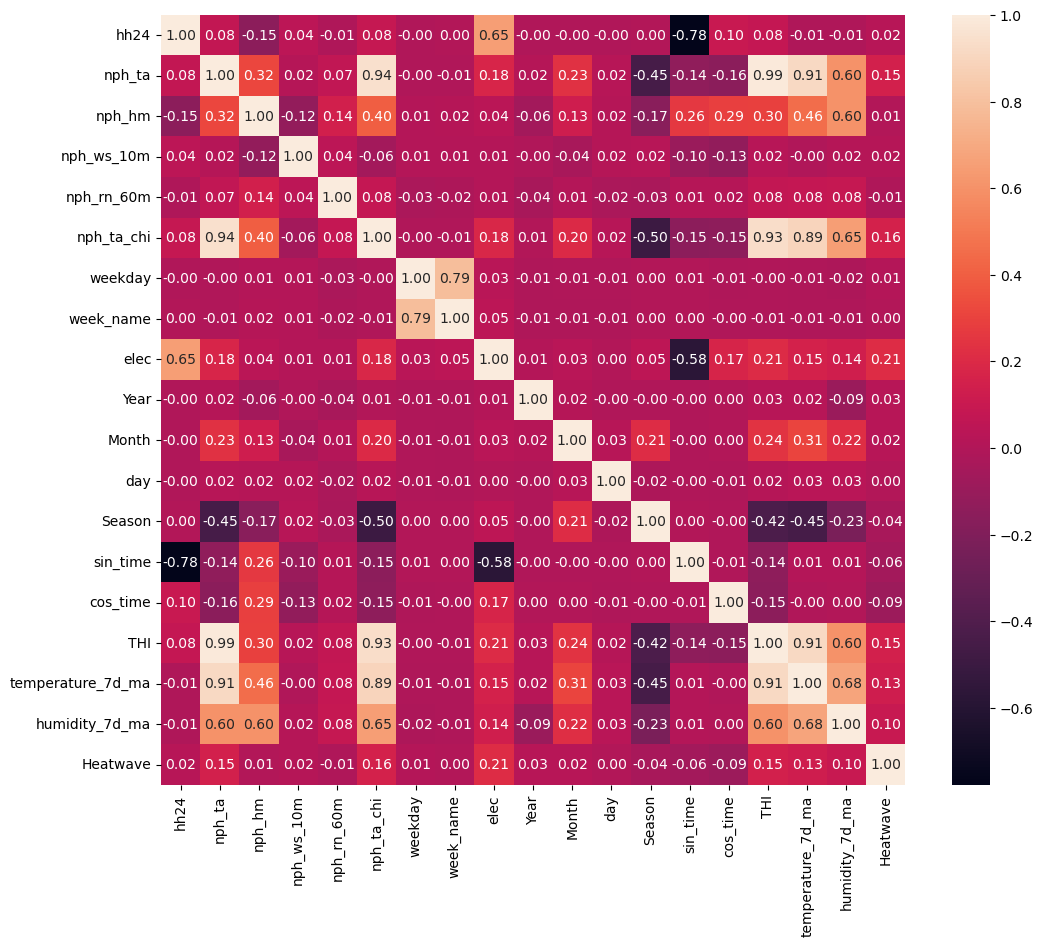

In [37]:
plt.figure(figsize = (12 , 10))
sns.heatmap(sampled_df.corr(), annot = True, fmt = '.2f')

In [38]:
train_sample.drop(['hh24', 'nph_ta', 'THI'],axis = 1, inplace = True)

sampled_df = train_sample.sample(10000, random_state = 42)
X_vif = sm.add_constant(sampled_df)
vif_data = pd.DataFrame()
vif_data['featufe'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)  # 삭제 후 다시 확인

              featufe           VIF
0               const  6.403687e+06
1              nph_hm  2.166034e+00
2          nph_ws_10m  1.103959e+00
3          nph_rn_60m  1.029514e+00
4          nph_ta_chi  7.648966e+00
5             weekday  2.664844e+00
6           week_name  2.668446e+00
7                elec  1.820750e+00
8                Year  1.025626e+00
9               Month  1.370363e+00
10                day  1.003106e+00
11             Season  1.685092e+00
12           sin_time  2.102678e+00
13           cos_time  1.446855e+00
14  temperature_7d_ma  7.389995e+00
15     humidity_7d_ma  2.514011e+00
16           Heatwave  1.090212e+00


In [39]:
# 최종적으로 삭제
train.drop(['hh24', 'nph_ta', 'THI'],axis = 1, inplace = True)
test.drop(['hh24', 'nph_ta', 'THI'], axis = 1, inplace = True)

In [40]:
############################################# 모델링
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [41]:
Y = train['elec']
X = train.drop(['elec'], axis = 1)

원핫인코딩 사용

In [42]:
X_encoded = pd.get_dummies(X, columns=['도시'])

In [43]:
#### 2020 ~ 2021년을 학습시켜 2022년 예측해보자

train_index = X_encoded[(X_encoded['Year'] >= 2020) & (X_encoded['Year'] <= 2021)].index
test_index = X_encoded[(X_encoded['Year'] >= 2022) & (X_encoded['Year'] <= 2023)].index

train_X_encoded = X_encoded.loc[train_index]
train_Y_encoded = Y.loc[train_index]

test_X_encoded = X_encoded.loc[test_index]
test_Y_encoded = Y.loc[test_index]

In [44]:
xgb_reg_one_hot = XGBRegressor() # 이상치 제거 전 0.9655, # 이상치 제거 후 0.9652 # 변수 제거 안하면 0.9661 # hh24 변수 제거하면 0.9657
xgb_reg_one_hot.fit(train_X_encoded, train_Y_encoded)
pred_xgb_reg_one_hot = xgb_reg_one_hot.predict(test_X_encoded)
correlation_xgb_reg_one_hot = np.corrcoef(pred_xgb_reg_one_hot, test_Y_encoded)[0, 1]
print(correlation_xgb_reg_one_hot) 

0.9655033143519294


In [45]:
xgb_reg_one_hot = XGBRegressor(tree_method = 'hist', n_estimators = 1000, learning_rate = 0.02, min_child_weight = 5)
xgb_reg_one_hot.fit(train_X_encoded, train_Y_encoded)
pred_xgb_reg_one_hot = xgb_reg_one_hot.predict(test_X_encoded)
correlation_xgb_reg_one_hot = np.corrcoef(pred_xgb_reg_one_hot, test_Y_encoded)[0, 1]
print(correlation_xgb_reg_one_hot) # 0.9680 # hh24 변수 제거하면 0.9685

0.9680588274764788


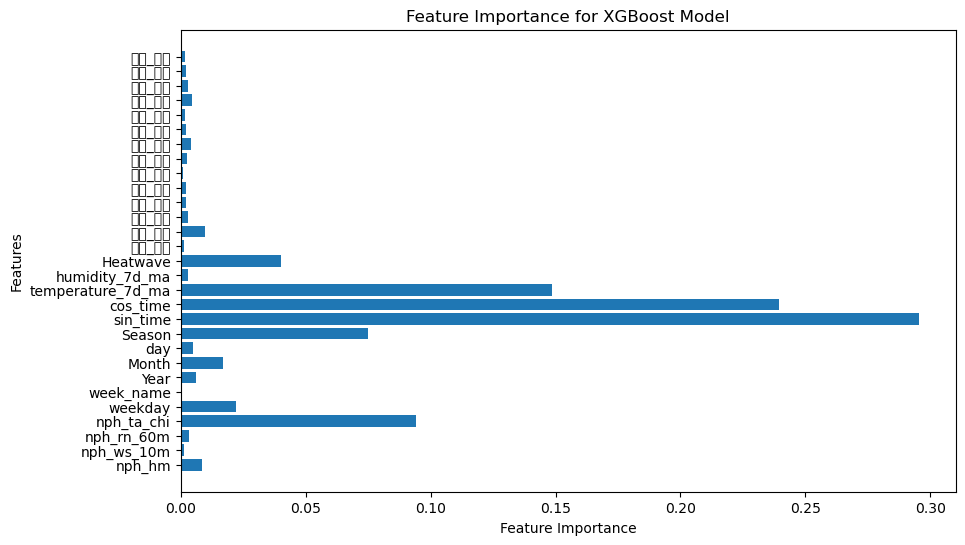

In [47]:
plt.figure(figsize=(10, 6))
plt.barh(train_X_encoded.columns, xgb_reg_one_hot.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGBoost Model')
plt.show()

In [51]:
# lgbm
def objective(trial):
    # 하이퍼파라미터 공간 설정
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'n_estimators': 1000,
        'random_state': 42,
        'verbosity': -1
    }
    train_data = lgb.Dataset(train_X_encoded, label=train_Y_encoded)
    valid_data = lgb.Dataset(test_X_encoded, label=test_Y_encoded)
    
    model = lgb.train(params, train_data, valid_sets=[train_data, valid_data]=)
    
    # 검증 데이터에 대한 예측
    y_pred = model.predict(test_X_encoded, num_iteration=model.best_iteration)
    
    # RMSE 평가
    correlation = np.corrcoef(test_Y_encoded, y_pred)[0, 1]
    return correlation

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# 최적의 하이퍼파라미터 출력
print('Best trial:')
print(study.best_trial.params)

[I 2024-06-19 19:25:21,679] A new study created in memory with name: no-name-c1300d92-8565-4ca8-a9c5-3cf3f856cd67
[I 2024-06-19 19:27:34,791] Trial 0 finished with value: 0.9684919565295345 and parameters: {'num_leaves': 55, 'learning_rate': 0.021926419780011128, 'subsample': 0.7521277676116245, 'colsample_bytree': 0.6025353794458111, 'reg_alpha': 1.431136977203822, 'reg_lambda': 0.010507161492430275}. Best is trial 0 with value: 0.9684919565295345.
[I 2024-06-19 19:30:07,384] Trial 1 finished with value: 0.967025785631391 and parameters: {'num_leaves': 96, 'learning_rate': 0.02061591006025602, 'subsample': 0.7841251227832667, 'colsample_bytree': 0.7048179952415093, 'reg_alpha': 0.0013782250986890427, 'reg_lambda': 0.008149854109697211}. Best is trial 1 with value: 0.967025785631391.
[I 2024-06-19 19:31:30,403] Trial 2 finished with value: 0.9677172066053721 and parameters: {'num_leaves': 24, 'learning_rate': 0.05473972277622757, 'subsample': 0.78944373112846, 'colsample_bytree': 0.773

Best trial:
{'num_leaves': 74, 'learning_rate': 0.06977861978165886, 'subsample': 0.7623323326563355, 'colsample_bytree': 0.7508857485404867, 'reg_alpha': 0.00591696109467895, 'reg_lambda': 0.13497442535405285}


In [44]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

def objective(trial: Trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }

    model = XGBRegressor(**param, random_state=42)
    model.fit(train_X_encoded, train_Y_encoded)
    preds = model.predict(test_X_encoded)
    rmse = mean_squared_error(test_Y_encoded, preds, squared=False)
    return rmse

# Optuna study 생성 및 최적화 실행
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=5)

print(f'Best hyperparameters: {study.best_params}')

[I 2024-06-18 23:47:37,223] A new study created in memory with name: no-name-1bc90a9a-baae-4f06-a26e-c7a1b7db6012
[I 2024-06-18 23:49:14,087] Trial 0 finished with value: 6.6826649420214626 and parameters: {'max_depth': 5, 'learning_rate': 0.07969454818643933, 'n_estimators': 759, 'min_child_weight': 6, 'gamma': 1.77071686435378e-07, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998}. Best is trial 0 with value: 6.6826649420214626.
[I 2024-06-18 23:52:02,032] Trial 1 finished with value: 6.599253489850078 and parameters: {'max_depth': 9, 'learning_rate': 0.015930522616241012, 'n_estimators': 737, 'min_child_weight': 1, 'gamma': 0.574485163632041, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381}. Best is trial 1 with value: 6.599253489850078.
[I 2024-06-18 23:53:02,166] Trial 2 finished with value: 15.224551733743914 and parameters: {'max_depth': 4, 'learning_rate': 0.002327067708383781, 'n_estimators': 374, 'min_child_weight': 6, 'gamma': 2

Best hyperparameters: {'max_depth': 9, 'learning_rate': 0.015930522616241012, 'n_estimators': 737, 'min_child_weight': 1, 'gamma': 0.574485163632041, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381}


In [53]:
# 주어진 최적의 하이퍼파라미터
best_params = {
    'max_depth': 9,
    'learning_rate': 0.015930522616241012,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'gamma': 0.574485163632041,
    'subsample': 0.9162213204002109,
    'colsample_bytree': 0.6061695553391381
}


Best_hyperparameters = {'max_depth': 7, 
                       'learning_rate': 0.01734075036613795, 
                       'n_estimators': 995, 
                       'min_child_weight': 10,
                       'gamma': 0.40080234127278613, 
                       'subsample': 0.8731905847762053, 
                       'colsample_bytree': 0.6413551958050462}

In [ ]:
# best_params = study.best_params
xgb_reg_optimized = XGBRegressor(**Best_hyperparameters)
xgb_reg_optimized.fit(train_X_encoded, train_Y_encoded)
pred_xgb_reg_optimized = xgb_reg_optimized.predict(test_X_encoded)
rmse_optimized = mean_squared_error(test_Y_encoded, pred_xgb_reg_optimized, squared=False)

correlation_optuna = np.corrcoef(pred_xgb_reg_optimized, test_Y_encoded)[0, 1]
print(correlation_optuna) # 0.969 

In [53]:
#### 2020 ~ 2021년을 학습시켜 2022년 예측해보자

train_index = X[(X['Year'] >= 2020) & (X['Year'] <= 2021)].index
test_index = X[(X['Year'] >= 2022) & (X['Year'] <= 2023)].index

train_X = X.loc[train_index]
train_Y = Y.loc[train_index]

test_X = X.loc[test_index]
test_Y = Y.loc[test_index]

라벨 인코딩

In [54]:
label_encoder = LabelEncoder()
train_X['city'] = label_encoder.fit_transform(train_X['도시'])
test_X['city'] = label_encoder.transform(test_X['도시'])

train_X.drop(['도시'], axis = 1, inplace = True)
test_X.drop(['도시'], axis = 1, inplace = True)

xgb_reg_first = XGBRegressor(random_state=42)
xgb_reg_first.fit(train_X, train_Y)
pred_xgb_reg_first = xgb_reg_first.predict(test_X)
correlation_xgb_reg_first = np.corrcoef(pred_xgb_reg_first, test_Y)[0, 1]
print(correlation_xgb_reg_first)

0.9655283552427587


In [55]:
xgb_reg_second = XGBRegressor(tree_method = 'hist', n_estimators = 1000, learning_rate = 0.02, min_child_weight = 5, random_state=42)
xgb_reg_second.fit(train_X, train_Y)
pred_xgb_reg_second = xgb_reg_second.predict(test_X)
correlation_xgb_reg_second = np.corrcoef(pred_xgb_reg_second, test_Y)[0, 1]
print(correlation_xgb_reg_second)

0.9678203431938636


최종 검증

In [55]:
test_valid = test

all_data = pd.concat([X, test_valid])
all_data = pd.get_dummies(all_data, columns = ['도시'])

X = all_data.iloc[:X.shape[0], :].reset_index(drop = True)
test_valid = all_data.iloc[X.shape[0]:, :].reset_index(drop = True)

In [62]:
xgb = XGBRegressor(tree_method = 'hist', n_estimators = 1000, learning_rate = 0.02, min_child_weight = 5, random_state=42)
xgb.fit(X, Y)
pred = xgb.predict(test_valid)


# 검증용 데이터
valid_set = pd.read_csv('/Users/jangjuik/Desktop/electric/code/electric_valid.csv')
valid_set['elect'] = pred

valid_set.to_csv('240106_re.csv')

In [56]:
# XGBoost 모델 초기화
model = XGBRegressor(**best_params)

# 모델 학습
model.fit(X, Y)

# 테스트 데이터에 대해 예측 수행
preds = model.predict(test_valid)


# 검증용 데이터
valid_set = pd.read_csv('/Users/jangjuik/Desktop/electric/code/electric_valid.csv')
valid_set['elect'] = preds

valid_set.to_csv('240106.csv')